In [4]:
import pandas as pd
from tqdm import tqdm


In [5]:
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

### Import Medication

In [8]:
# Import entire excel file
xl = pd.ExcelFile("d/BAG_xls_2019/Publications-20190501.xlsx")

In [9]:
# Looking at sheets. It turns out its the file 
# GL_Diff_SB_DE I need to work with, as this
# ones contains coding for the type of product,
# whether they are generica or original products.
xl.sheet_names

['Publications',
 'Generika',
 'Packungen_20%SB',
 'GL_Diff_SB_DE',
 'Publications_FR',
 'Generika_FR',
 'Packungen_20%SB_FR',
 'GL_Diff_SB_FR']

In [10]:
pa = xl.parse("GL_Diff_SB_DE")

In [26]:
pub = xl.parse("Publications")
pub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9349 entries, 0 to 9348
Data columns (total 18 columns):
Hersteller                  9345 non-null object
Generika                    5317 non-null object
Pharmacode                  0 non-null float64
BAG-Dossier                 9328 non-null float64
Swissmedic-Nr.              9336 non-null float64
Swissmedic-Liste            9340 non-null object
Einf.-Datum                 9349 non-null object
Bezeichnung                 9349 non-null object
Exf-Preis per 01.05.2019    9297 non-null float64
Pub-Preis per 01.05.2019    9333 non-null float64
Limitation                  2204 non-null object
Lim-Pkte                    148 non-null float64
Therap. Gruppe              9349 non-null object
Substanzen                  9302 non-null object
Rec-ID                      9349 non-null int64
20% Selbstbehalt            9349 non-null object
GTIN                        9093 non-null float64
ATC                         9343 non-null object
dtypes: f

In [24]:
# Working out the original medication and generica 
# with the biggest difference.
# First by ATC Number (Which is this: https://www.whocc.no/atc_ddd_index/)
# And then by the size of the packet.

In [12]:
#testing with N02BB02
t = pa[pa['ATC']== "N02BB02"]
m = t[t['Packung']=="100 ml"]
max_ = t[t['Packung']=="100 ml"]['Pub.Preis'].max()
min_ = t[t['Packung']=="100 ml"]['Pub.Preis'].min()
herstellerO = m[m['Pub.Preis']==max_]["Hersteller"]
herstellerO = str(herstellerO).split("    ")[1].split("\n")[0]

In [13]:
newdf = []

#These are the lists
ATC = list(set(list(pa['ATC'])))

for atc in tqdm(ATC):
    t = pa[pa['ATC']== atc]
    PAC = list(set(list(t["Packung"])))
    
    for pac in PAC:
        
        m = t[t['Packung']==pac]
        DOS = list(set(list(m["gal.Form-Dosis"])))
        
        for dos in DOS:
            f = m[m['gal.Form-Dosis']==dos]
            
            max_ = f[f['Packung']==pac]['Pub.Preis'].max()
            min_ = f[f['Packung']==pac]['Pub.Preis'].min()
        
            herstellerO = f[f['Pub.Preis']==max_]["Hersteller"]
            herstellerO = str(herstellerO).split("    ")[1].split("\n")[0]
            herstellerG = f[f['Pub.Preis']==min_]["Hersteller"]
            herstellerG = str(herstellerG).split("    ")[1].split("\n")[0]
            präparatO = f[f['Pub.Preis']==max_]["Präparat"]
            präparatO = str(präparatO).split("    ")[1].split("\n")[0]
            präparatG = f[f['Pub.Preis']==min_]["Präparat"]
            präparatG = str(präparatG).split("    ")[1].split("\n")[0]
            PriceO = f[f['Pub.Preis']==max_]["Pub.Preis"]
            PriceO = str(PriceO).split("    ")[1].split("\n")[0]
            PriceG = f[f['Pub.Preis']==min_]["Pub.Preis"]
            PriceG = str(PriceG).split("    ")[1].split("\n")[0]
            RECIDO = f[f['Pub.Preis']==max_]["RECID"]
            RECIDO = str(RECIDO).split("    ")[1].split("\n")[0]
            RECIDG = f[f['Pub.Preis']==min_]["RECID"]
            RECIDG = str(RECIDG).split("    ")[1].split("\n")[0]
            percent = (max_ - min_)/min_*100
            minidict = {'Company O':herstellerO,
                'Original':präparatO,
                'Company G':herstellerG,
                'Genericum':präparatG,
                'ATC': atc,
                'Price O': PriceO,
                'Price G': PriceG,
                'Percent Diff': percent,
                'Packing':pac,
                'Dosage':dos,
                'RECIDO':RECIDO,
                'RECIDG':RECIDG}
            
            newdf.append(minidict)


100%|██████████| 291/291 [00:47<00:00,  5.38it/s]


In [14]:
df = pd.DataFrame(newdf).dropna()
pd.set_option('max_colwidth', 80)

In [15]:
# If Original and Generic are the same, delete the row
def f(elem1,elem2):
    if elem1 == elem2:
        return True
    else:
        return False
df['Checking'] = df[['Genericum', 'Original']].apply(lambda x: f(*x), axis=1)
df = df[df['Checking']==False]
del df['Checking']

In [16]:
df.sort_values(by='Percent Diff', ascending=False).head()

,ATC,Company G,Company O,Dosage,Genericum,Original,Packing,Percent Diff,Price G,Price O,RECIDG,RECIDO
893,N03AX16,Pfizer PFE Switzerland GmbH,Pfizer PFE Switzerland GmbH,Kaps 50 mg,Pregabalin Pfizer,Lyrica,14 Stk,200.000000,8.55,25.65,34815,34726
896,N03AX16,Pfizer PFE Switzerland GmbH,Pfizer PFE Switzerland GmbH,Kaps 75 mg,Pregabalin Pfizer,Lyrica,14 Stk,199.462366,9.3,27.85,34817,14600
878,N03AX16,Pfizer PFE Switzerland GmbH,Pfizer PFE Switzerland GmbH,Kaps 300 mg,Pregabalin Pfizer,Lyrica,168 Stk,171.733668,119.4,324.45,34823,14607
877,N03AX16,Pfizer PFE Switzerland GmbH,Pfizer PFE Switzerland GmbH,Kaps 150 mg,Pregabalin Pfizer,Lyrica,168 Stk,164.881890,95.25,252.3,34820,14604
892,N03AX16,Pfizer PFE Switzerland GmbH,Pfizer PFE Switzerland GmbH,Kaps 25 mg,Pregabalin Pfizer,Lyrica,56 Stk,155.968170,18.85,48.25,34814,34725


In [17]:
df.to_csv('output/generics_diff.csv', index=False)

In [18]:
df.sort_values(by='Percent Diff', ascending=False).drop_duplicates(subset='ATC', keep='first').head(10)

,ATC,Company G,Company O,Dosage,Genericum,Original,Packing,Percent Diff,Price G,Price O,RECIDG,RECIDO
893,N03AX16,Pfizer PFE Switzerland GmbH,Pfizer PFE Switzerland GmbH,Kaps 50 mg,Pregabalin Pfizer,Lyrica,14 Stk,200.000000,8.55,25.65,34815,34726
2187,C10AA07,Drossapharm AG,AstraZeneca AG,Filmtabl 10 mg,Rosuvastax,Crestor,30 Stk,153.333333,18.75,47.5,38134,15907
853,N05AH03,Mepha Pharma AG,Eli Lilly (Suisse) SA,Tabl 20 mg,Olanzapin Mepha,Zyprexa Velotab,28 Stk,151.396253,141.45,355.6,30747,13339
1782,C09DA06,Sandoz Pharmaceuticals AG,AstraZeneca AG,Tabl 32/25 mg,Co-Candesartan Sandoz,Atacand plus,28 Stk,146.191646,20.35,50.1,32688,24589
1416,N06AB10,,Lundbeck (Schweiz) AG,Tropfen 20 mg/ml,Escitalopram Mepha,Cipralex,15 ml,144.444444,18.9,46.2,34844,30794
2780,C10AA05,Mepha Pharma AG,Pfizer PFE Switzerland GmbH,Filmtabl 40 mg,Atorvastatin Mepha Teva,Sortis,100 Stk,118.241279,68.8,150.15,38259,13527
2367,S01ED01,Santen SA,Ursapharm Schweiz GmbH,Gtt Opht 0.250 %,Timoptic,Timo Comod,5 ml,118.055556,7.2,15.7,11120,14666
1363,J05AF07,Mylan Pharma GmbH,Gilead Sciences Switzerland Sàrl,Filmtabl 245 mg,Tenofovirdisoproxil Mylan 245 mg,Viread,30 Stk,116.446980,254.15,550.1,40021,13684
235,C09CA06,Mepha Pharma AG,AstraZeneca AG,Tabl 16 mg,Cansartan Mepha,Atacand,28 Stk,112.000000,17.5,37.1,31512,844
2214,N02AA55,Sandoz Pharmaceuticals AG,"Mundipharma Medical Company Hamilton,Bermuda,B...",Ret Tabl 5 mg/2.5 mg,Oxycodon-Naloxon Sandoz,Targin,30 Stk,110.160428,18.7,39.3,36786,29582


In [19]:
#work out the average price difference per ATC category

In [20]:
df['ATC Times more expensive average'] = df['Price O'].astype(float) / df['Price G'].astype(float)

In [21]:
av_atc = pd.DataFrame(df.groupby('ATC')['ATC Times more expensive average'].mean())
df = df.merge(av_atc, left_on='ATC', right_index=True)

In [22]:
df.sort_values('ATC Times more expensive average_y', ascending=False).drop_duplicates(subset='ATC', keep='first').head(10)

,ATC,Company G,Company O,Dosage,Genericum,Original,Packing,Percent Diff,Price G,Price O,RECIDG,RECIDO,ATC Times more expensive average_x,ATC Times more expensive average_y
891,N03AX16,Pfizer PFE Switzerland GmbH,Pfizer PFE Switzerland GmbH,Kaps 150 mg,Pregabalin Pfizer,Lyrica,56 Stk,123.468208,43.25,96.65,34821,14603,2.234682,2.488819
2191,C10AA07,Drossapharm AG,AstraZeneca AG,Filmtabl 20 mg,Rosuvastax,Crestor,30 Stk,122.423146,27.65,61.5,38136,15909,2.224231,2.384976
1363,J05AF07,Mylan Pharma GmbH,Gilead Sciences Switzerland Sàrl,Filmtabl 245 mg,Tenofovirdisoproxil Mylan 245 mg,Viread,30 Stk,116.446980,254.15,550.1,40021,13684,2.164470,2.164470
841,N05AH03,Mepha Pharma AG,Eli Lilly (Suisse) SA,Tabl 10 mg,Olanzapin Mepha,Zyprexa Velotab,28 Stk,135.864198,81.0,191.05,30745,12806,2.358642,2.154460
2367,S01ED01,Santen SA,Ursapharm Schweiz GmbH,Gtt Opht 0.250 %,Timoptic,Timo Comod,5 ml,118.055556,7.2,15.7,11120,14666,2.180556,2.144765
1786,C09DA06,Sandoz Pharmaceuticals AG,AstraZeneca AG,Tabl 16/12.5 mg,Co-Candesartan Sandoz,Atacand plus,98 Stk,76.605505,54.5,96.25,29290,12668,1.766055,2.126466
2780,C10AA05,Mepha Pharma AG,Pfizer PFE Switzerland GmbH,Filmtabl 40 mg,Atorvastatin Mepha Teva,Sortis,100 Stk,118.241279,68.8,150.15,38259,13527,2.182413,2.102731
1294,L01BC07,Accord Healthcare AG,Celgene GmbH,Trockensub 100 mg,Azacitidin Accord,Vidaza,Durchstf 1 Stk,94.029578,273.85,531.35,39651,15598,1.940296,1.940296
2608,L01XE01,Sandoz Pharmaceuticals AG,Novartis Pharma Schweiz AG,Filmtabl 100 mg,Imatinib Sandoz,Glivec,60 Stk,85.478917,716.2,1328.4,36272,13971,1.854789,1.854789
2195,N02AA55,Sandoz Pharmaceuticals AG,"Mundipharma Medical Company Hamilton,Bermuda,B...",Ret Tabl 20 mg/10 mg,Oxycodon-Naloxon Sandoz,Targin,60 Stk,89.926471,68.0,129.15,36793,25632,1.899265,1.854228


In [14]:
df['Percent Diff'].describe()

count    812.000000
mean      27.968484
std       33.330697
min        0.072939
25%        6.644774
50%       15.007508
75%       33.831731
max      200.000000
Name: Percent Diff, dtype: float64

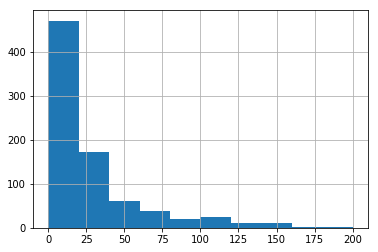

In [15]:
df['Percent Diff'].hist()

In [16]:
df[df['Percent Diff']

SyntaxError: unexpected EOF while parsing (<ipython-input-16-2f76e5726736>, line 1)